# Road lane line detection with FCN architecture

We use [this pre-processed TuSimple](https://www.kaggle.com/datasets/hikmatullahmohammadi/tusimple-dataset-preprocessed) dataset in this notebook.

In [1]:
!pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

In [3]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                      title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
bhadramohit/customer-shopping-latest-trends-dataset      Customer Shopping (Latest Trends) Dataset    76KB  2024-11-23 15:26:12          20073        393  1.0              
abdulmalik1518/the-ultimate-cars-dataset-2024            The Ultimate Cars Dataset 2024               25KB  2024-12-30 14:45:41            671         26  1.0              
govindaramsriram/sleep-time-prediction                   Sleep Time Prediction                        28KB  2024-12-28 17:08:56           1211         31  1.0              
hopesb/student-depression-dataset                        Student Depression Dataset.                 454KB  2024-11-22 17:56:03        

In [5]:
!kaggle datasets download -d hikmatullahmohammadi/tusimple-preprocessed

Dataset URL: https://www.kaggle.com/datasets/hikmatullahmohammadi/tusimple-preprocessed
License(s): unknown
tusimple-preprocessed.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
import zipfile

# Unzip the downloaded dataset
with zipfile.ZipFile("tusimple-preprocessed.zip", "r") as zip_ref:
    zip_ref.extractall("tusimple-dataset-preprocessed")

print("Dataset extracted successfully!")

Dataset extracted successfully!


In [7]:
import os

# List the files in the extracted dataset folder
dataset_path = "tusimple-dataset-preprocessed"
print(os.listdir(dataset_path))

['tusimple_preprocessed']


In [8]:
# import required libraries/dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, Sequential

In [9]:
# train path
train_path = './tusimple-dataset-preprocessed/tusimple_preprocessed/training'

In [10]:
# create a generator and get the images from the directory
img_generator = keras.preprocessing.image.ImageDataGenerator()
seed = 10
images_set = img_generator.flow_from_directory(
    train_path,
    shuffle=False,
    batch_size=64,
    class_mode='binary',
    target_size=(256, 320)
)

Found 7252 images belonging to 2 classes.


Actually, the images do not belong to two classes. Rather, there are two directories, one for images and one for their corresponding lane masks. So in the cell bellow, we handle it: seperate assign the images to X and y

In [11]:
'''
Assign the images in 'images_set' to two seperate arrays:
assign the road images to 'X' and the ground truth masks to 'Y'
'''
num_images = 7252 # gotten from the output of the cell above
num_batches = num_images // 64 + 1

# initialize an empty list to store the images
X = []
Y = []
# loop over the batches and extract the images
for i in range(num_batches):
    batch = next(images_set)
    batch_images = batch[0] # this contains the images
    batch_labels = batch[1] # this contains 0s and 1s
    for ind, lb in enumerate(batch_labels):
        '''
        a label of 0 means the image belongs to ground truth image,
        and a label of 1 means that the image belongs to the ground truth mask
        '''
        if lb == 0:
            X.append(batch_images[ind])
        else:
            Y.append(np.mean(batch_images[ind], axis=2)) # Y shape is (m, 256, 320)
    if i % 10 == 0:
        print(f'Batch {i}')

# convert the lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Batch 50
Batch 60
Batch 70
Batch 80
Batch 90
Batch 100
Batch 110


In [12]:
# shuffle the dataset
from sklearn.utils import shuffle

X, Y = shuffle(X, Y, random_state=100)

# Modeling

In [13]:
# Normalize and reshape the mask set (Y)
Y = (Y >= 100).astype('int').reshape(-1, 256, 320, 1)

In [14]:
Y.min(), Y.max()

(0, 1)

In [15]:
# we get 2000 images for training and evaluation
X = np.array(X[:2000])
Y = np.array(Y[:2000])

In [16]:
# Split the datset into train and val sets
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=.1, random_state=100)

In [17]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of Y_val:", Y_val.shape)

Shape of X_train: (1800, 256, 320, 3)
Shape of X_val: (200, 256, 320, 3)
Shape of Y_train: (1800, 256, 320, 1)
Shape of Y_val: (200, 256, 320, 1)


In [18]:
# free the RAM from undesired clutters
import gc
del X, Y, images_set
gc.collect()

0

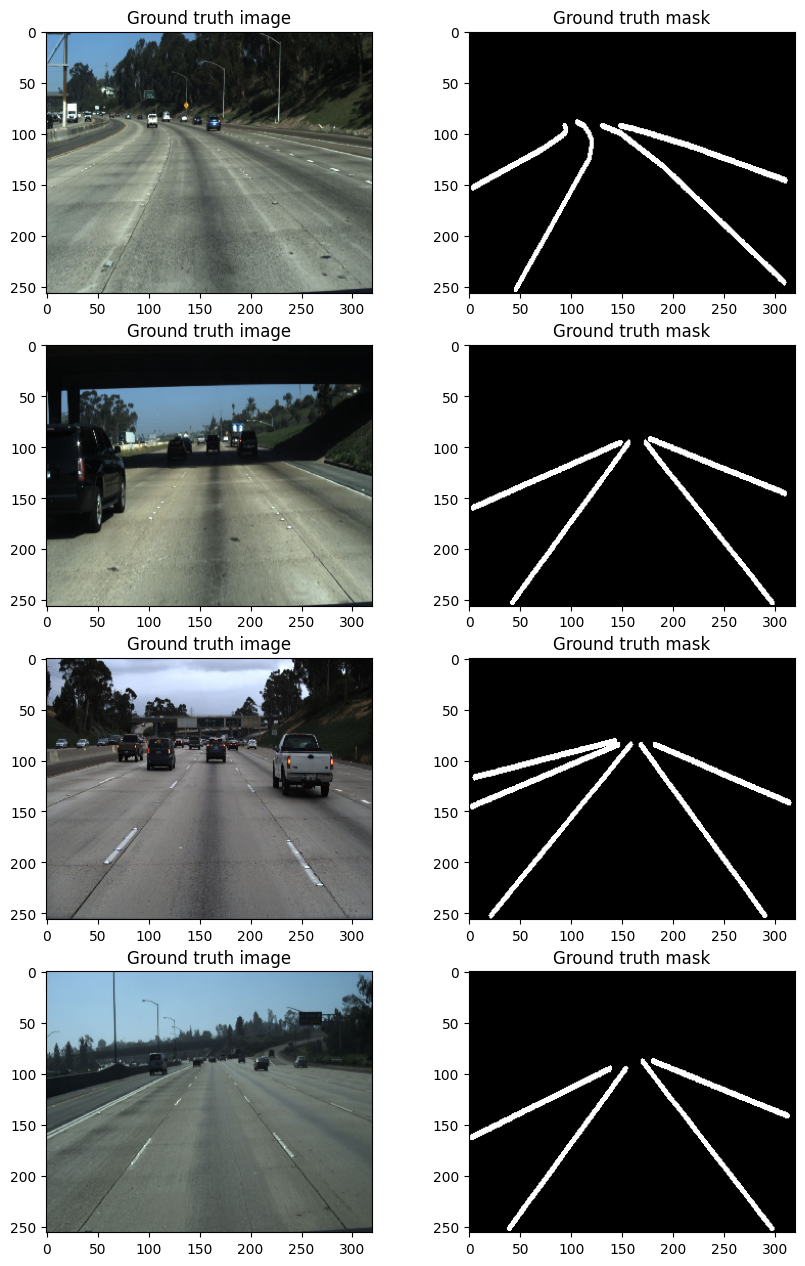

In [19]:
# visualize some samples from the training set
plt.figure(figsize=(10, 40))
s, e = 80, 84
index = 1

for i, j in zip(X_train[s:e], Y_train[s:e]):
    plt.subplot(10, 2, index)
    plt.imshow(i/255.)
    plt.title('Ground truth image')

    plt.subplot(10, 2, index+1)
    plt.imshow(j, cmap='gray')
    plt.title('Ground truth mask')
    index += 2

In [20]:
# model structure
from keras.layers import Input, Conv2DTranspose, Conv2D, MaxPooling2D
from keras.applications.resnet50 import ResNet50
from tensorflow.keras.regularizers import l2

# Define the input shape of the images
input_shape = (256, 320, 3)

# Define the encoder using a pretrained ResNet50 model
encoder = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

'''
Find the index of the layer named conv3_block4_out of which output size is (32x32xnC)
 because we want to shrink the input's size down upto (32x32xnC) in the encoder section
'''

for i, layer in enumerate(encoder.layers):
    if layer.name == 'conv3_block4_out':
        break

# Create a new model that includes only the layers up to conv3_block4_out
encoder = tf.keras.Model(inputs=encoder.inputs, outputs=encoder.layers[i].output)

# Freeze the weights of the encoder layers to prevent them from being updated during training
for layer in encoder.layers[:50]:
    layer.trainable = False

# Define the decoder using a smaller FCN architecture
def decoder(inputs):
    conv1 = Conv2D(256, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(0.01))(inputs)
    up1 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(0.01))(up1)
    up2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(0.01))(up2)
    up3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(up3)
    return outputs

# Define the input tensor
inputs = Input(input_shape)

# Pass the input through the encoder and decoder to obtain the output
outputs = decoder(encoder(inputs))

# Define the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [21]:
# Compile the model

model.compile(optimizer='adam', loss=keras.losses.BinaryFocalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 320, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional (Functional)              │ (None, 32, 40, 512)         │       1,460,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 40, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 64, 80, 256)         │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 80, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 128, 160, 128)       │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 160, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 256, 320, 64)        │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 256, 320, 1)         │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,353,409 (12.79 MB)

 Trainable params: 2,735,809 (10.44 MB)

 Non-trainable params: 617,600 (2.36 MB)

In [22]:
from tensorflow.keras.callbacks import Callback

class MetricsLogger(Callback):
    def __init__(self, X_val, Y_val):
        super().__init__()
        self.X_val = X_val
        self.Y_val = Y_val
        self.epoch_metrics = {
            "accuracy": [],
            "precision": [],
            "recall": [],
            "f1_score": [],
            "iou": []
        }

    def on_epoch_end(self, epoch, logs=None):
        preds = (self.model.predict(self.X_val) >= 0.5).astype("int")

        # Calculate metrics
        accuracy = tf.keras.metrics.Accuracy()
        precision = tf.keras.metrics.Precision()
        recall = tf.keras.metrics.Recall()
        iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])

        accuracy.update_state(self.Y_val, preds)
        precision.update_state(self.Y_val, preds)
        recall.update_state(self.Y_val, preds)
        iou.update_state(self.Y_val, preds)

        accuracy_value = accuracy.result().numpy()
        precision_value = precision.result().numpy()
        recall_value = recall.result().numpy()
        f1_score_value = 2 / ((1 / precision_value) + (1 / recall_value))
        iou_value = iou.result().numpy()

        # Store metrics
        self.epoch_metrics["accuracy"].append(accuracy_value)
        self.epoch_metrics["precision"].append(precision_value)
        self.epoch_metrics["recall"].append(recall_value)
        self.epoch_metrics["f1_score"].append(f1_score_value)
        self.epoch_metrics["iou"].append(iou_value)

        print(
            f"Epoch {epoch + 1} - Accuracy: {accuracy_value:.4f}, Precision: {precision_value:.4f}, Recall: {recall_value:.4f}, "
            f"F1 Score: {f1_score_value:.4f}, IoU: {iou_value:.4f}"
        )

# Instantiate the custom metrics logger
metrics_logger = MetricsLogger(X_val, Y_val)


In [23]:
# train the model
epochs = 32
batch_size = 8

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),metrics_logger
]

model.fit(
    X_train,
    Y_train,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_val, Y_val),
    batch_size=batch_size
)

Epoch 1/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 444ms/step
Epoch 1 - Accuracy: 0.9708, Precision: 0.7082, Recall: 0.5608, F1 Score: 0.6259, IoU: 0.4555
225/225 ━━━━━━━━━━━━━━━━━━━━ 80s 230ms/step - accuracy: 0.9458 - loss: 1.0901 - val_accuracy: 0.9708 - val_loss: 0.0206
Epoch 2/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
Epoch 2 - Accuracy: 0.9740, Precision: 0.7544, Recall: 0.5989, F1 Score: 0.6677, IoU: 0.5011
225/225 ━━━━━━━━━━━━━━━━━━━━ 36s 117ms/step - accuracy: 0.9715 - loss: 0.0200 - val_accuracy: 0.9740 - val_loss: 0.0193
Epoch 3/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step
Epoch 3 - Accuracy: 0.9724, Precision: 0.8580, Recall: 0.4396, F1 Score: 0.5814, IoU: 0.4098
225/225 ━━━━━━━━━━━━━━━━━━━━ 43s 128ms/step - accuracy: 0.9751 - loss: 0.0173 - val_accuracy: 0.9724 - val_loss: 0.0213
Epoch 4/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step
Epoch 4 - Accuracy: 0.9755, Precision: 0.7946, Recall: 0.5880, F1 Score: 0.6759, IoU: 0.5105
225/225 ━━━━━━━━━━━━━━━━━━━━ 40s 125ms/step - accuracy: 0.9764 - lo

In [24]:
preds = model.predict(X_val)
preds.max(), preds.min()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


(0.97688454, 4.5291163e-11)

In [25]:
# make a directory to store some predicted lane masks
!mkdir out

mkdir: cannot create directory ‘out’: File exists


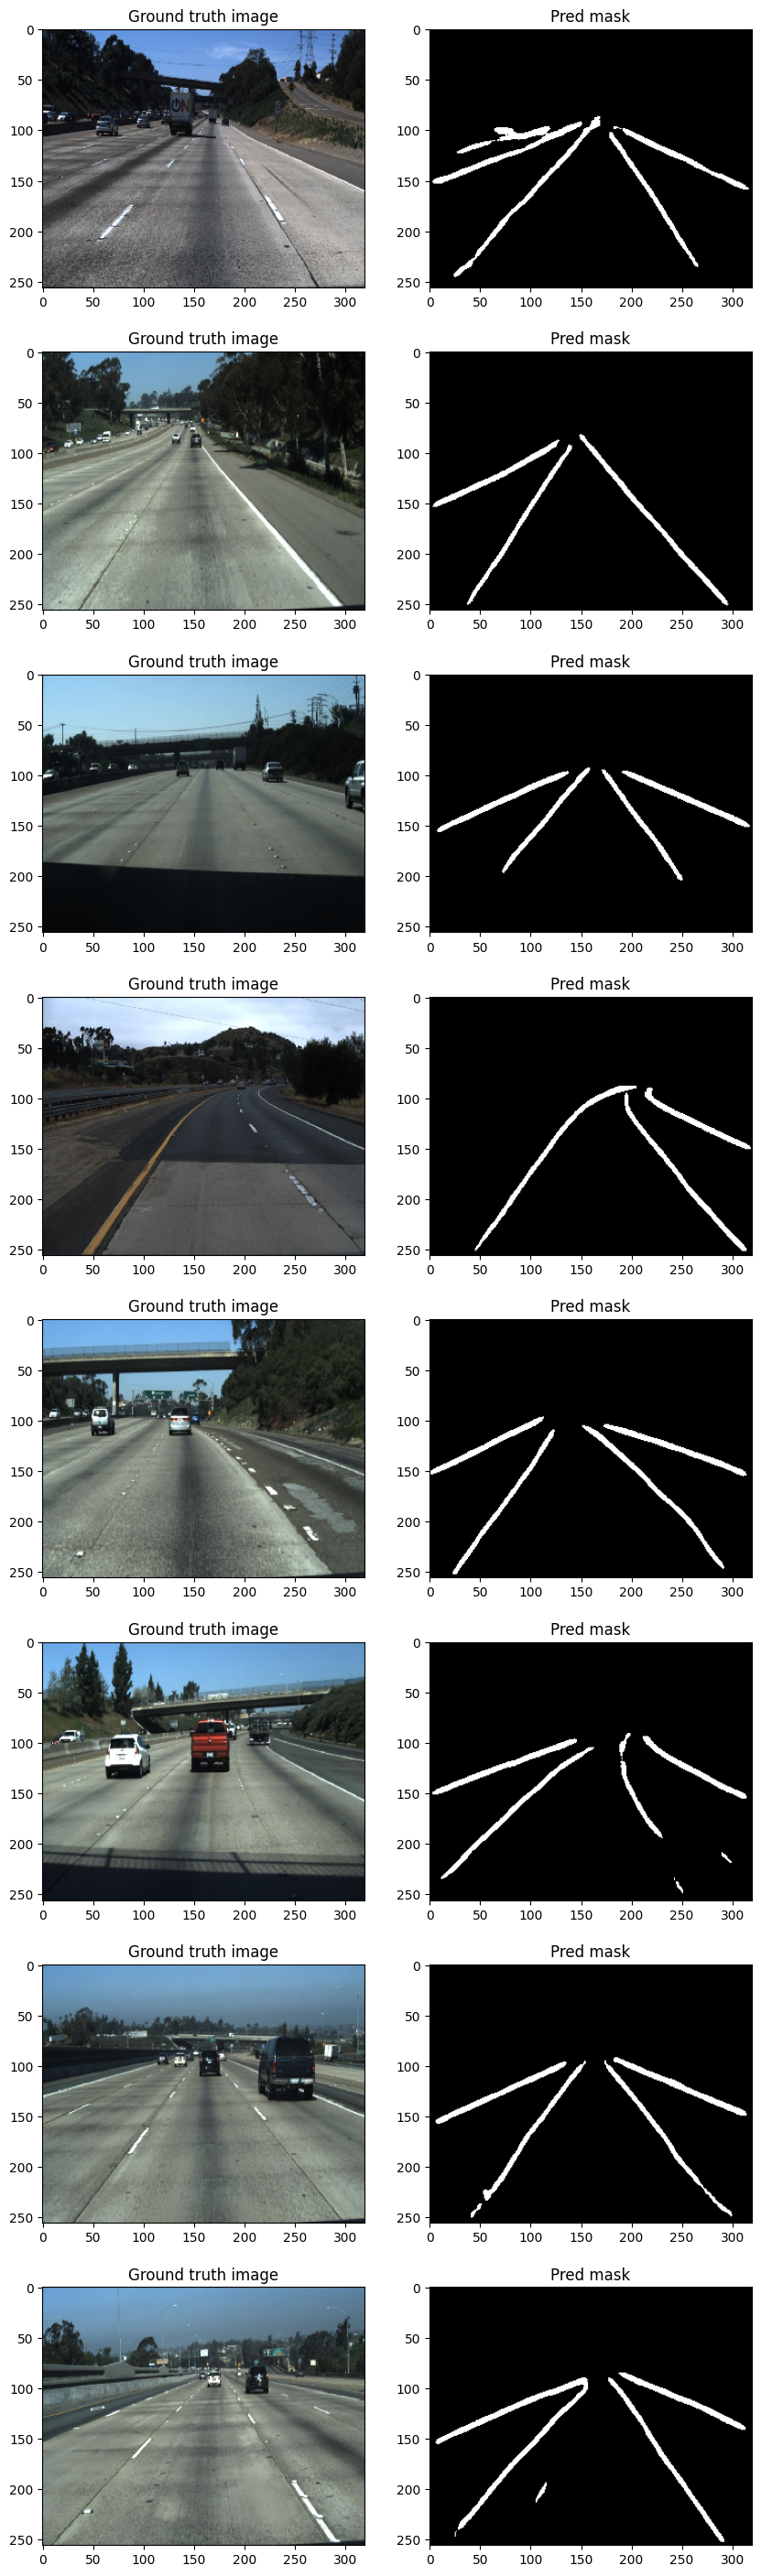

In [26]:
# visualize some results from the val set.
plt.figure(figsize=(10, 45))
s, e = 90, 98
index = 1

preds = (preds >= .5).astype('int')
for i, j, k in zip(X_val[s:e], preds[s:e], Y_val[s:e]):
    # write these images into file as well
    cv2.imwrite(f'./out/img-{index}.jpg', i)
    cv2.imwrite(f'./out/pred-{index}.jpg', j*255.)
    cv2.imwrite(f'./out/ground-{index}.jpg', k*255.)

    plt.subplot(10, 2, index)
    plt.imshow(i/255.)
    plt.title('Ground truth image')

    plt.subplot(10, 2, index+1)
    plt.imshow(j, cmap='gray')
    plt.title('Pred mask')
    index += 2

In [27]:
# zip 'out' folder
!zip out.zip out -r -q

In [28]:
# save the model
model.save('/lane-detection-model-fcn.keras')

In [29]:
# create metrices
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recal = tf.keras.metrics.Recall()
iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])


# accuracy
accuracy.update_state(Y_val, preds)
accuracy_value = accuracy.result().numpy()
# precision
precision.update_state(Y_val, preds)
precision_value = precision.result().numpy()
# recal
recal.update_state(Y_val, preds)
recal_value = recal.result().numpy()
# f1 score
f1_score = 2 / ((1 / precision_value) + (1 / recal_value))

# Intersection over union (IoU)
iou.update_state(Y_val, preds)
iou_value = iou.result().numpy()

print("Accuracy:", accuracy_value)
print("Precision:", precision_value)
print("Recall:", recal_value)
print('F1 Score: ', f1_score)
print('IoU: ', iou_value)

Accuracy: 0.97796494
Precision: 0.7808368
Recal: 0.68652916
F1 Score:  0.7306524117950252
IoU:  0.5756125


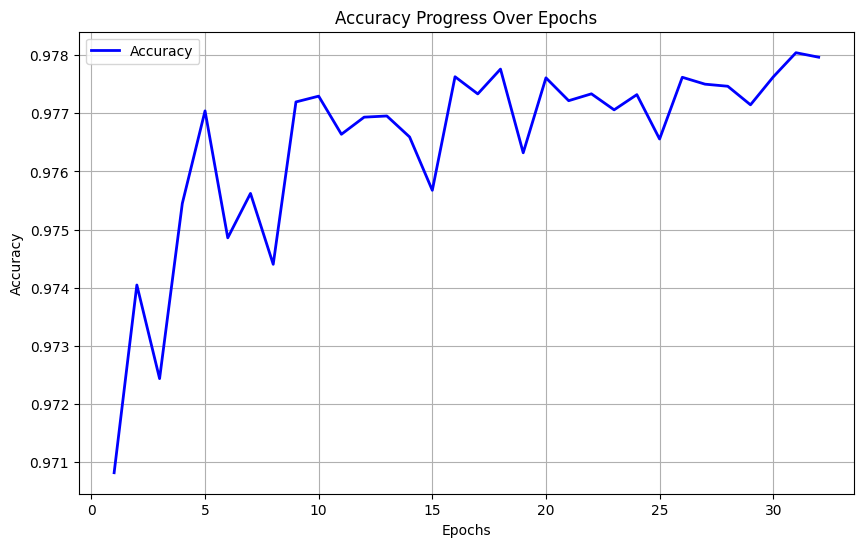

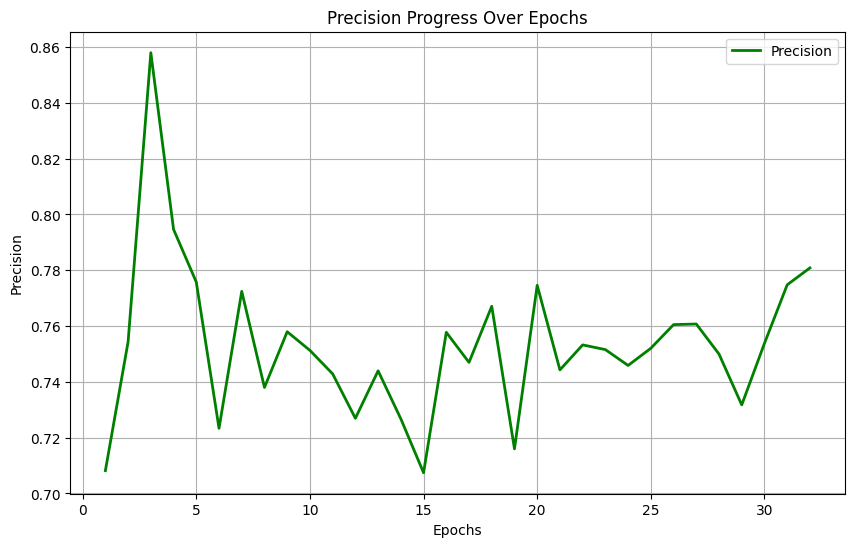

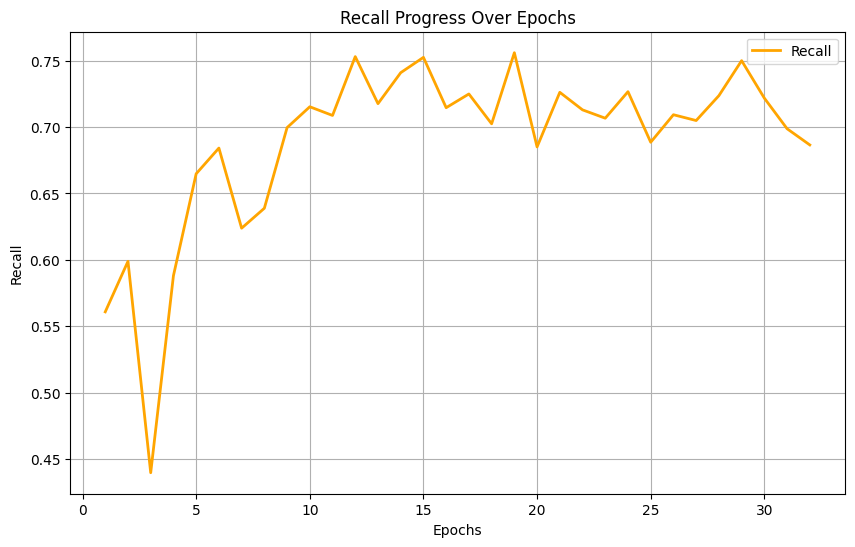

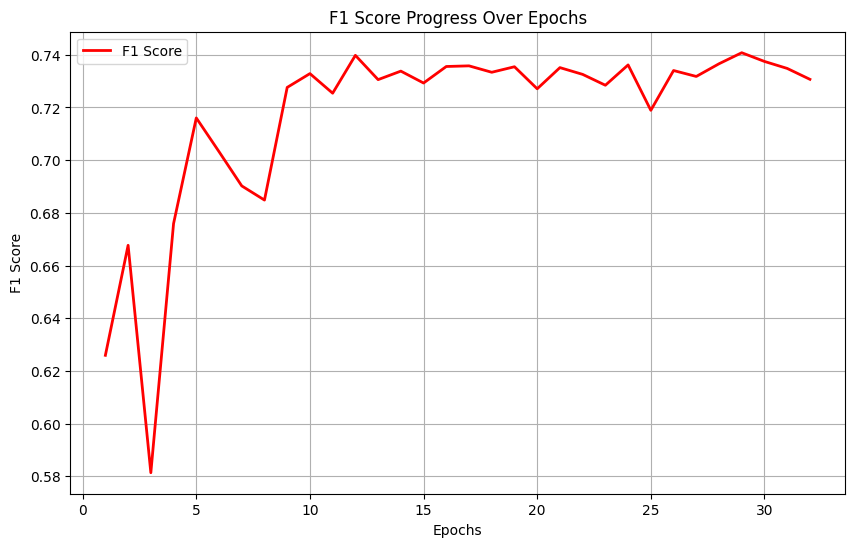

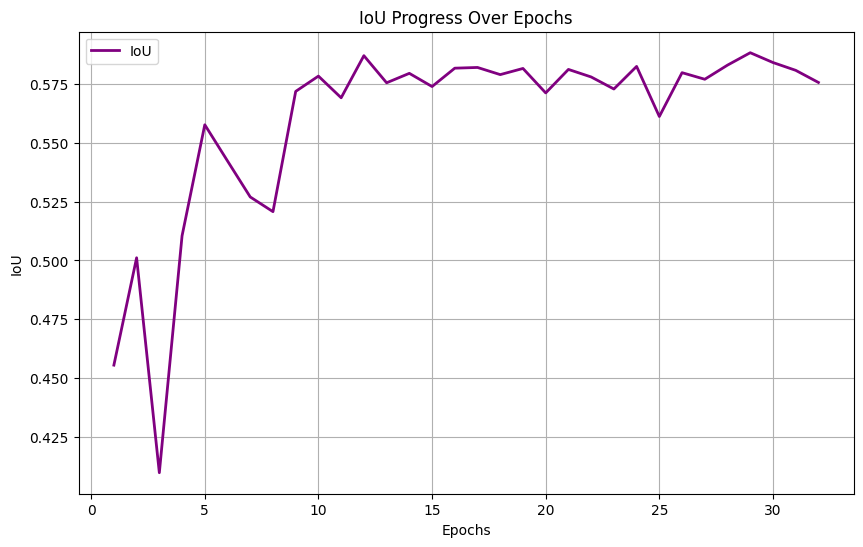

In [30]:
# Extract metrics
epoch_list = range(1, len(metrics_logger.epoch_metrics["accuracy"]) + 1)
accuracy = metrics_logger.epoch_metrics["accuracy"]
precision = metrics_logger.epoch_metrics["precision"]
recall = metrics_logger.epoch_metrics["recall"]
f1_score = metrics_logger.epoch_metrics["f1_score"]
iou = metrics_logger.epoch_metrics["iou"]

# Plot Accuracy Progress
plt.figure(figsize=(10, 6))
plt.plot(epoch_list, accuracy, label="Accuracy", color="blue", linewidth=2)
plt.title("Accuracy Progress Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Plot Precision Progress
plt.figure(figsize=(10, 6))
plt.plot(epoch_list, precision, label="Precision", color="green", linewidth=2)
plt.title("Precision Progress Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

# Plot Recall Progress
plt.figure(figsize=(10, 6))
plt.plot(epoch_list, recall, label="Recall", color="orange", linewidth=2)
plt.title("Recall Progress Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend()
plt.grid(True)
plt.show()

# Plot F1 Score Progress
plt.figure(figsize=(10, 6))
plt.plot(epoch_list, f1_score, label="F1 Score", color="red", linewidth=2)
plt.title("F1 Score Progress Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.show()

# Plot IoU Progress
plt.figure(figsize=(10, 6))
plt.plot(epoch_list, iou, label="IoU", color="purple", linewidth=2)
plt.title("IoU Progress Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2

def predict_lane_image(image_path, model, debug=True):
    """
    Predicts lane lines with preprocessing matching training pipeline exactly.

    Args:
    - image_path: str, path to the input image
    - model: trained keras model for lane detection
    - debug: bool, whether to print debug information
    """
    try:
        # Load image
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Could not load image from {image_path}")

        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if debug:
            print("\nInput Image Stats:")
            print(f"Original shape: {img.shape}")
            print(f"Original range: {img.min()} to {img.max()}")

        # Resize to model's input size
        img = cv2.resize(img, (320, 256))

        # Normalize
        img = img.astype('float32')
        img = img / 255.0

        if debug:
            print(f"\nAfter preprocessing:")
            print(f"Shape: {img.shape}")
            print(f"Value range: {img.min():.3f} to {img.max():.3f}")
            print(f"Mean value: {img.mean():.3f}")

        # Add batch dimension
        img_batch = np.expand_dims(img, axis=0)

        # Make prediction
        prediction = model.predict(img_batch, verbose=0)

        if debug:
            print("\nPrediction Stats:")
            print(f"Prediction shape: {prediction.shape}")
            print(f"Prediction range: {prediction.min():.3f} to {prediction.max():.3f}")
            print(f"Mean prediction: {prediction.mean():.3f}")

        # Try different thresholds
        thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
        plt.figure(figsize=(20, 4))

        # Original image
        plt.subplot(161)
        plt.imshow(img)
        plt.title('Input Image')
        plt.axis('off')

        # Show results with different thresholds
        for i, thresh in enumerate(thresholds, 2):
            binary_mask = (prediction[0] >= thresh).astype('uint8')
            plt.subplot(1, 6, i)
            plt.imshow(binary_mask[:, :, 0], cmap='gray')
            plt.title(f'Threshold {thresh}')
            plt.axis('off')

            if debug:
                print(f"\nThreshold {thresh}:")
                print(f"Percentage of lane pixels: {(binary_mask.sum() / binary_mask.size) * 100:.2f}%")

        # Raw prediction probabilities
        plt.subplot(166)
        plt.imshow(prediction[0, :, :, 0], cmap='jet')
        plt.colorbar()
        plt.title('Probability Map')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Return the standard threshold result (0.5)
        binary_mask = (prediction[0] >= 0.5).astype('uint8')
        return binary_mask, prediction

    except Exception as e:
        print(f"Error during prediction: {str(e)}")
        raise

# Additional helper function to check model's weights
def check_model_weights(model):
    """Print information about model's weights to verify it's properly loaded"""
    print("\nModel Weights Check:")
    for layer in model.layers:
        weights = layer.get_weights()
        if weights:  # if layer has weights
            print(f"\nLayer: {layer.name}")
            for i, w in enumerate(weights):
                print(f"Weight {i} shape: {w.shape}")
                print(f"Weight {i} range: {w.min():.3f} to {w.max():.3f}")

# Test the model and check weights
check_model_weights(model)


image_path = "test_image.jpg"

# Run prediction
mask, pred = predict_lane_image(image_path, model)


# Final Results

Test Image

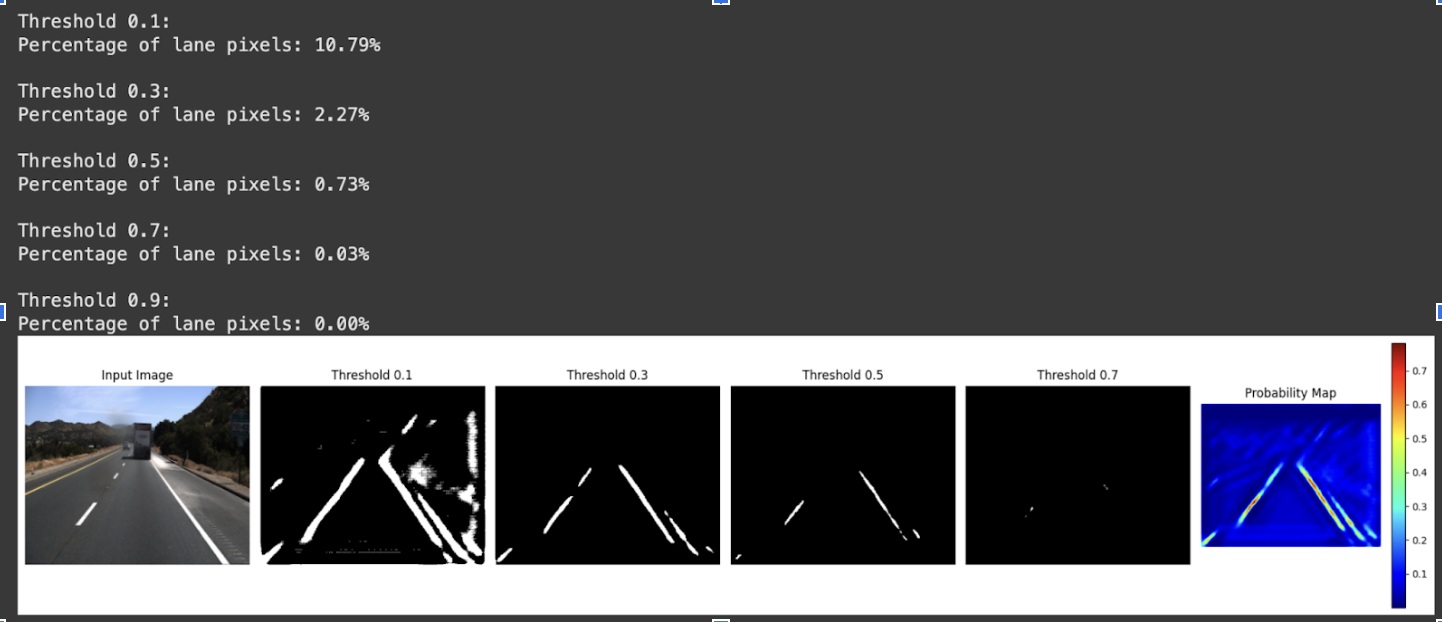

Graphs

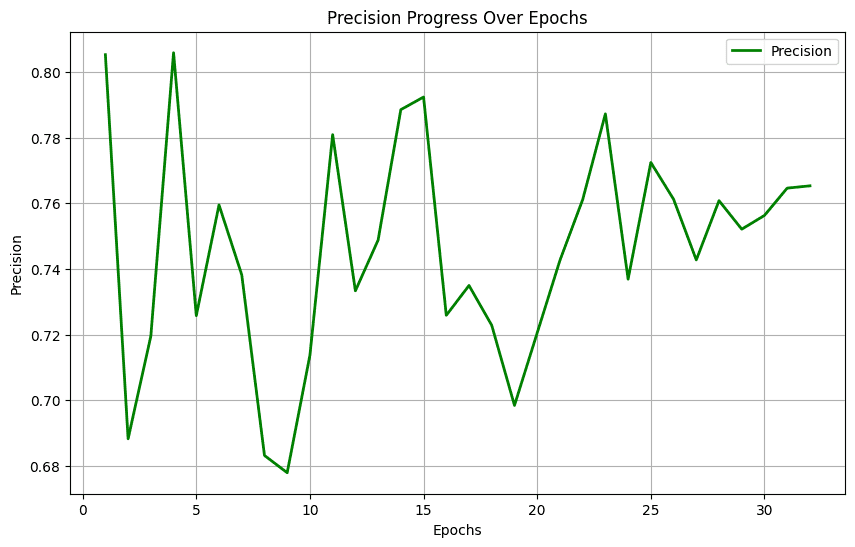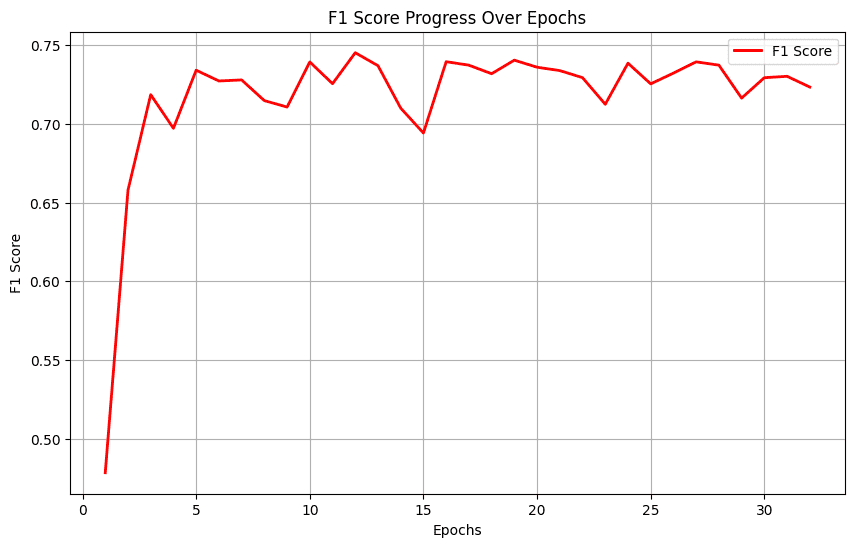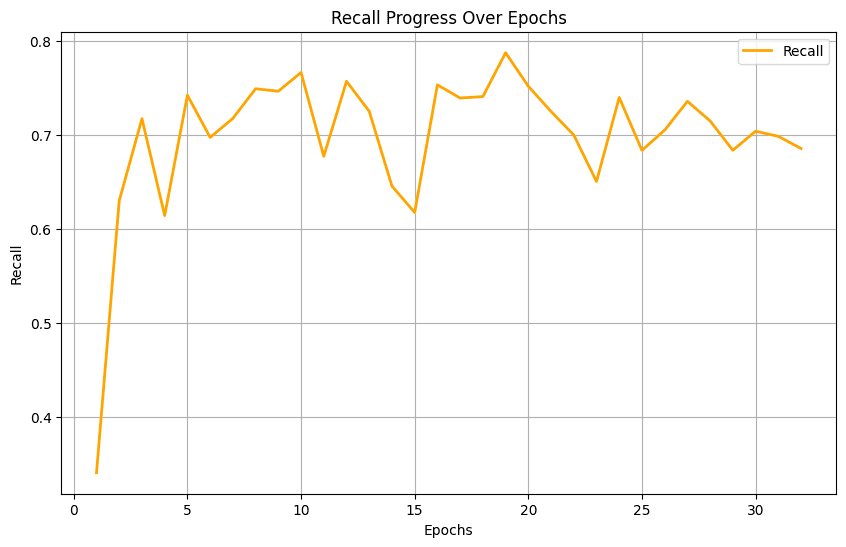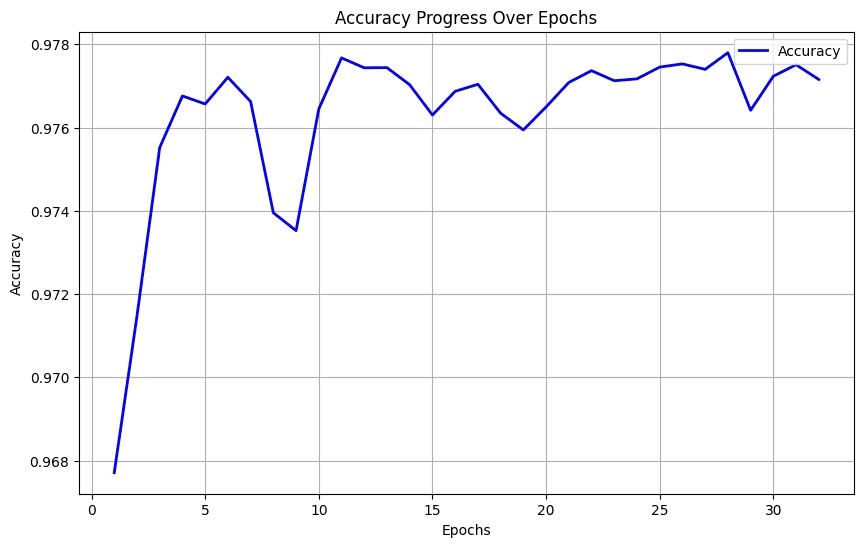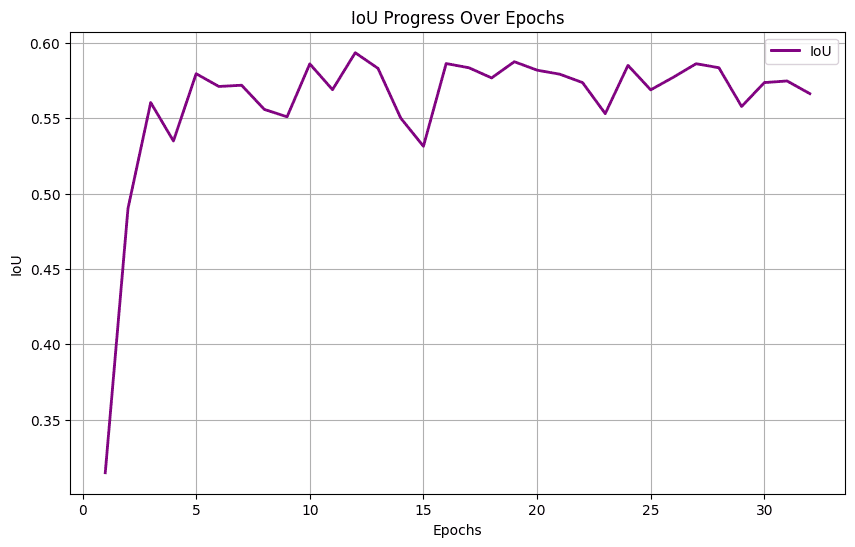